In [1]:
#libraries import

import os
import numpy as np

from numpy.random import shuffle

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import Normalizer

# Defining relevant functions

In [3]:
def rotatii_posibile(init_value):
    # PURPOSE: computes possible texture codes (i.e rotations, shifts) of a 
    #          rotation invariant texture pattern code
    #
    # PARAMETERS: init_value: texture pattern code to be shifted
    #                        
    #
    # RETURNS: list_shifts: list of possible texture codes that belong
    #                       within the set of the rotation invariant texture code
    
    value = init_value
    list_shifts=[] 
    looped=False
    
    while not looped:
        value=value<<1
        if value&256==256:value-=255
        if value==init_value:
             looped = True
        list_shifts.append(value)
    return list_shifts

def creare_tabel_rotatii_v2():
    # PURPOSE: creates an identification table through which a base texture code
    #          can be associated to a rotation invariant texture code
    #
    # RETURNS: table: the identification table
    
    table=[]
    tipuri=np.asanyarray([1, 17, 33, 65, 73, 81, 85, 129, 133, 137, 145, 149, 153, 161, 165, 169, 177, 181, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253])
    for rotatie in range (34):
        table.append(rotatii_posibile(tipuri[rotatie]))
    return table

#the identification table is being compiled
TABEL = creare_tabel_rotatii_v2()

def gaseste_rotatia_minima (numar, tabel_de_rotatii =TABEL):
    # PURPOSE: identifies the minimal value of a base texture code using the
    #          identification table 
    #
    # PARAMETERS: numar: base texture code to be identified formatted as an integer
    #             tabel_de_rotatii: the aforementioned identification table
    #
    # RETURNS: minimal value of the base texture code identified using the identification table
    
    if numar == 0: return 0
    elif numar ==255: return 255
    for rotatie in range(34):
        lungime =len(tabel_de_rotatii[rotatie][:])
        for versiune in range(lungime):
            if numar == tabel_de_rotatii[rotatie][versiune]: return np.min(tabel_de_rotatii[rotatie][:])
    return -1

def Descriptori_LBP_RGB(matrix,t): 
    # PURPOSE: computes the base LTP texture descriptor of a given image
    #
    # PARAMETRI: matrix: image to be extracted
    #            t: the selected noise threshold 
    #
    # RETURNEAZA: histcorob: the base LTP texture descriptor of the given image
    
    histcorob=np.zeros(1536,dtype=np.float64)
    t=np.float64(t)
    h,w = matrix[:,:,0].shape
    for plan_culoare in range(3):
        for i in range (1,h-1):
            for j in range(1,w-1):
                CODE_POZ=0
                CODE_NEG=0
                c=np.float64(matrix[i][j][plan_culoare])
     # "diffs" stores all the substractions made between the reference pixel and its "neighbours"
                diffs=np.float64([matrix[i][j-1][plan_culoare],
                                  matrix[i+1][j-1][plan_culoare],
                                  matrix[i+1][j][plan_culoare],
                                  matrix[i+1][j+1][plan_culoare],
                                  matrix[i][j+1][plan_culoare],
                                  matrix[i-1][j+1][plan_culoare],
                                  matrix[i-1][j][plan_culoare],
                                  matrix[i-1][j-1][plan_culoare]])-np.float64(c)

                CODE_POZ+= 1<<7 if diffs[0]>=t else 0   #MSB
                CODE_NEG+= 1<<7 if diffs[0]<=-t else 0

                CODE_POZ+= 1<<6 if diffs[1]>=t else 0
                CODE_NEG+= 1<<6 if diffs[1]<=-t else 0

                CODE_POZ+= 1<<5 if diffs[2]>=t else 0
                CODE_NEG+= 1<<5 if diffs[2]<=-t else 0

                CODE_POZ+= 1<<4 if diffs[3]>=t else 0
                CODE_NEG+= 1<<4 if diffs[3]<=-t else 0

                CODE_POZ+= 1<<3 if diffs[4]>=t else 0
                CODE_NEG+= 1<<3 if diffs[4]<=-t else 0

                CODE_POZ+= 1<<2 if diffs[5]>=t else 0
                CODE_NEG+= 1<<2 if diffs[5]<=-t else 0

                CODE_POZ+= 1<<1 if diffs[6]>=t else 0
                CODE_NEG+= 1<<1 if diffs[6]<=-t else 0

                CODE_POZ+= 1 if diffs[7]>=t else 0
                CODE_NEG+= 1 if diffs[7]<=-t else 0     #LSB

                histcorob[CODE_POZ + 256 * (plan_culoare * 2) ]+=1
                histcorob[CODE_NEG + 256 * (plan_culoare * 2 + 1) ]+=1

    return histcorob

def Descriptori_LTP_invarianti(hist_ltp):
    # PURPOSE: computes rotation invariant texture descriptors based off of
    #          the complementary base texture descriptors
    #
    # PARAMETERS: hist_ltp: the Local Ternary pattern (LTP) base texture descriptor to be converted
    #
    # RETUNRS: histcorobi: the rotation invariant LTP texture descriptor
    
    pseudoidx={0:0, 1:1, 17:2, 9:3, 5:4, 37:5, 21:6, 85:7, 3:8, 11:9, 
              19:10, 25:11, 43:12, 51:13, 13:14, 45:15, 53:16, 27:17, 91:18, 7:19, 
              23:20, 39:21, 55:22, 29:23, 87:24, 59:25, 119:26, 15:27, 47:28, 61:29, 
              111:30, 31:31, 95:32, 63:33, 127:34, 255:35}

    histcorobi = np.zeros(216,dtype=np.float64)
    for i in range(256):
        
        index = pseudoidx [gaseste_rotatia_minima (i)]

        #RED channel
        histcorobi[index]+=hist_ltp[i]                       
        histcorobi[index+36]+=hist_ltp[i+256]

        #GREEN channel
        histcorobi[index+36*2]+=hist_ltp[i + 256*2]                       
        histcorobi[index+36*3]+=hist_ltp[i + 256*3]

        #BLUE channel
        histcorobi[index+36*4]+=hist_ltp[i + 256*4]                       
        histcorobi[index+36*5]+=hist_ltp[i + 256*5]

    return histcorobi

def extrage_predictii (model_analizat,partitie_test,sanitizare_CNN:bool):   
    # PURPOSE: computes and returns the list of predicted labels and the list of
    #          ground truth labels using the test partition
    #
    # PARAMETERS: model_analizat: the classifier that's being used
    #             partitie_test:  the test partition
    #             sanitizare_CNN: if the selected classifier is of CNN type,
    #                             needs to be set to True in order to perform
    #                             necessary image resizing
    #
    # RETURNS:   ytrue: the ground truth labels
    #            ypred: the predicted labels

    ytrue = []
    ypred = []

    for lot in partitie_test.as_numpy_iterator():
        vectori_lot = []
        etichete_lot = lot[1]
        
        for i in range(len(lot[0])):
            vectori_lot .append(lot[0][i].copy())
        
        if sanitizare_CNN:
            for i in range(len(vectori_lot)):
                if vectori_lot [i].shape != (400,400):
                    vectori_lot [i] = cv2.resize(vectori_lot [i], (400, 400), interpolation=cv2.INTER_AREA)
            
        vectori_lot = np.array(vectori_lot)
        procentaje_incredere = model_analizat.predict(vectori_lot,batch_size = len(vectori_lot),verbose = 0)

        for i in range(len(procentaje_incredere)):
            ytrue.append(np.argmax(etichete_lot[i]))
            ypred.append(np.argmax(procentaje_incredere[i]))
            
    
    return (ytrue, ypred)


def afiseaza_matrice_confuzie (ytrue, ypred, nume_model, colorbar = False):
    # PURPOSE: plots the confusion matrix according to effective number of classified examples,
    #          as well as according to classification percentages normalized over the ground truth labels.
    #
    # PARAMETERS: ytrue: ground truth labels
    #             ypred: predicted labels
    #             nume_model: name of the model for identification
    #             colorbar: 'bool' colorbar option
    
    disp_title = 'Confusion Matrix of the given classifier ' + nume_model + ' according to:'
    disp_labels = ['Ac','As','Cb','Cc','Ci','Cs','Ct','Cu','Ns','Sc','St']
    
    axes = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
    axes.append(ax1)
    axes.append(ax2)
    
    matrix = confusion_matrix (ytrue, ypred)
    
    for pos in range(len(axes)):
        if pos == 1: matrix = np.round(confusion_matrix (ytrue, ypred, normalize ='true'),2)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):

                if i == j:

                    if matrix [i,j]  < 30:  axes[pos].text(j, i, matrix[i, j], ha='center', va='center', color='#0ad122', fontweight = 'demibold')
                    else: axes[pos].text(j, i, matrix[i, j], ha='center', va='center', color='#03ff21', fontweight = 'demibold')

                elif matrix[i,j] != 0:

                    if matrix [i,j] <30: 
                        axes[pos].text(j, i, matrix[i, j], ha='center', va='center', color='#de150b', fontweight = 'demibold')
                    else: 
                        axes[pos].text(j, i, matrix[i, j], ha='center', va='center', color='#f5180c', fontweight = 'demibold')


        axes[pos].set_xticks(ticks=np.arange(len(disp_labels)), labels=disp_labels)                    
        axes[pos].set_yticks(ticks=np.arange(len(disp_labels)), labels=disp_labels)

        axes[pos].set_xlabel ('Predicted Labels', fontsize = 12, labelpad = 10, fontweight = 'demi')
        axes[pos].set_ylabel ('True Labels', fontsize = 12, labelpad = 10, fontweight = 'demi')

        

        if pos == 0:
            axes[pos].set_title ('A) Effective number of predicted labels',pad = 25, fontsize = 13)
        else:
            axes[pos].set_title ('B) Percentages of true label i predicted across label j [%]',pad = 25, fontsize = 13)
        
        axes[pos].imshow(matrix, cmap='Greys', interpolation='none', aspect= 0.8)   

    if colorbar: plt.colorbar()  

    plt.suptitle ( disp_title, y = 0.694, fontweight = 'bold')
    plt.savefig (MODEL_NAME+'.png',dpi=150, bbox_inches='tight',pad_inches = 0.1)
    plt.show()
    return



def calculeaza_metrici_performanta (ytrue, ypred, print_results = True):
    # PURPOSE: computes and optionally prints out performance metrics computed 
    #          per class, micro-averaged, macro-averaged
    #
    # PARAMETERS: ytrue: ground truth labels
    #             ypred: predicted labels
    #             print_results: formats and prints metrics if set to True
    #                           
    # RETURNS: output: a dict structure containing the performance metrics
    
    eps = 0.000001 #very small value covering cases of zero division
    
    precizie = precision_score (ytrue, ypred,average = None, zero_division = 0.0)
    reamintire = recall_score(ytrue,ypred, average = None, zero_division = 0.0)
    f1_scor = 2 * ( np.multiply(precizie,reamintire) / (precizie + reamintire + eps) )
    
    prec_micro = precision_score (ytrue, ypred,average = 'micro', zero_division = 0.0)
    rec_micro = recall_score (ytrue, ypred,average = 'micro', zero_division = 0.0)
    f1sc_micro = 2 * ( (prec_micro * rec_micro) / (prec_micro + rec_micro + eps) )
    
    prec_macro = precision_score (ytrue, ypred,average = 'macro', zero_division = 0.0)
    rec_macro = recall_score (ytrue, ypred,average = 'macro', zero_division = 0.0)
    f1sc_macro = 2* ( (prec_macro * rec_macro) / (prec_macro + rec_macro + eps) )
    
    #the dict structure
    output = dict (precizie_micro = prec_micro, reamintire_micro = rec_micro, F1_micro = f1sc_micro,
                   precizie_macro = prec_macro, reamintire_macro = rec_macro, F1_macro =f1sc_macro,
                   precizie_clase = precizie, reamintire_clase = reamintire, F1_clase = f1_scor)
    
    if print_results:
        print('1) PERFORMANCE METRICS PER CLASS:\n')
        
        cap_tabel  = 'Class'+' '*2 + '|'+ ' Precision  ' + '|' + '    Recall    ' + '|' + '  F1-score  '+ '|'
        linie = '-'*len(cap_tabel)
        separator = '-'*7 + '|' + '-'*12 +'|'+'-'*14+'|'+'-'*12+'|'

        print(cap_tabel)
        print(linie)
        for i in range(len(precizie)):
            offset_precizie = len('|'+ '  Precizie') - len(str(f'{precizie[i]:.2f}')) -1 #-1 ca sa fie indexat cum trebuie
            offset_reamintire = len('|' + '  Reamintire') - len(str(f'{reamintire[i]:.2f}')) -1
            offset_fscore = len('|' + '  F1-score') - len(str(f'{f1_scor[i]:.2f}')) -1

            rand_valori = (cloudict[i] + ' '*5 + '|' 
                      + ' ' *offset_precizie + str(f'{precizie[i]:.2f}') + '  |' 
                      + ' ' *offset_reamintire + str(f'{reamintire[i]:.2f}') +'  |'
                      + ' ' *offset_fscore + str(f'{f1_scor[i]:.2f}')+ '  |')

            print(rand_valori)
            print(separator)
            
        print('\n2) MICRO-AVERAGED PERFORMANCE METRICS:\n')
        print(f'   Precision_micro: {prec_micro:.2f}\n   Recall_micro: {rec_micro:.2f}\n   F1score_micro: {f1sc_micro:.2f}')
        
        print('\n3) MACRO-AVERAGED PERFORMANCE METRICS:\n')
        print(f'   Precision_macro: {prec_macro:.2f}\n   Recall_macro: {rec_macro:.2f}\n   F1score_macro: {f1sc_macro:.2f}\n')
        
    return output



# Selecting the desired classifier

In [4]:
#general purpose variables (MUST BE RUN)
cloudict = {0:'Ac', 1:'As' , 2:'Cb' , 3:'Cc' , 4:'Ci' , 5:'Cs' , 6:'Ct' , 7:'Cu' , 8:'Ns' , 9:'Sc' , 10:'St' }
batch_size = 128
norma_l1 = Normalizer (norm = 'l1')

In [5]:
# SELECTING THE PROPER CLASSIFIER AND LOADING DATA
tip_clasificator = ''
zgomot = 0
selected = False

data = None

while not selected:
    tip_clasificator = input('Select desired classifier type (either CNN, BASE or INVARIANT):')
    if not tip_clasificator in ['CNN','BASE','INVARIANT']:
        print('Invalid classifier type.')
    else: 
        selected = True
        print(f'Classifier type {tip_clasificator} selected for training.\n')

if tip_clasificator == 'CNN':
    sourcedir='/kaggle/input/ccsn-public/CCSN_v2' 
    try:
        os.listdir(sourcedir)
    except Exception as e: sourcedir='/kaggle/input/CCSN_v2'
    data = tf.keras.utils.image_dataset_from_directory(sourcedir,batch_size=128,image_size=(400,400),label_mode='categorical',shuffle = True)
    data = data.map(lambda x,y:(x/255,y))
    
else: 
    selected = False
    while not selected:
        zgomot = int(input('Select the noise threshold value (either 0, 2 or 5):'))
        if not zgomot in [0,2,5]:
            print('Invalid noise threshold value.')
        else: 
            selected = True
            print(f'Noise threshold value {zgomot} selected for training.\n')
    
    print('Preparing data for training...\n')
    
    backpath = '/kaggle/input/descriptori-ltp-ccsn'     
    try:
        os.listdir(backpath)
    except Exception as e: backpath ='/kaggle/input'

    TOBESHUFFLED = []

    for turn in range(11):
      backfile=os.path.join(backpath,'ZGOMOT_'+str(zgomot),'LTP_'+str(zgomot)+'_'+cloudict[turn]+'.bin')
      extracting = True
      with open (backfile, 'rb') as f:
        counts = 0
        while extracting:
            histogram = np.fromfile(f, count = 1536 , dtype=np.float64)
            if histogram.size == 0:
              print(f'Class {cloudict[turn]} file loaded {counts} base LTP descriptors.')
              extracting = False
            else:
                PAIR = []

                templabel = np.zeros(11)
                templabel [turn] = 1

                histogrami = Descriptori_LTP_invarianti(histogram)

                PAIR.append(histogram)
                PAIR.append(histogrami)
                PAIR.append(templabel)

                TOBESHUFFLED.append(PAIR)
                counts += 1

    shuffle(TOBESHUFFLED)
    LABELS = []
    DESCRIPTORS = []
    DESCRIPTORSINV = []

    for i in range(len(TOBESHUFFLED)):
        DESCRIPTORS.append(TOBESHUFFLED[i][0])
        DESCRIPTORSINV.append(TOBESHUFFLED[i][1])
        LABELS.append(TOBESHUFFLED[i][2])

    del TOBESHUFFLED
    
    DESCRIPTORS = np.array(DESCRIPTORS)
    DESCRIPTORSINV = np.array(DESCRIPTORSINV)
    
    lungime_1 = 1536
    lungime_2 = 216

    sesime_1 = lungime_1//6
    sesime_2 = lungime_2//6
    
    for i in range(0,lungime_1,sesime_1):
        DESCRIPTORS[:,i:i+sesime_1] = norma_l1.fit_transform(DESCRIPTORS[:,i:i+sesime_1])

    for i in range(0 , lungime_2, sesime_2):
        DESCRIPTORSINV[:,i:i + sesime_2 ] = norma_l1.fit_transform(DESCRIPTORSINV[:,i:i + sesime_2])
        
    if tip_clasificator == 'BASE':
        data = tf.data.Dataset.from_tensor_slices((DESCRIPTORS,LABELS)).batch(batch_size)
    else:
        data = tf.data.Dataset.from_tensor_slices((DESCRIPTORSINV,LABELS)).batch(batch_size)
    
    del DESCRIPTORS, DESCRIPTORSINV, LABELS

print('\nThe dataset has been shuffled and properly scaled.')

# training/validation/testing partition sizes

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
print('\nPARTITION DIMENSIONS:\nTrain: {0}\nVal: {1}\nTest: {2}'.format(train_size,val_size,test_size))

# partitioning the data

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

iteration = 0 #defines model iteration

print('\nTraining, validation and testing subsets have been successfully partitioned.')

Select desired classifier type (either CNN, BASE or INVARIANT): INVARIANT


Classifier type INVARIANT selected for training.



Select the noise threshold value (either 0, 2 or 5): 5


Noise threshold value 5 selected for training.

Preparing data for training...

Class Ac file loaded 221 base LTP descriptors.
Class As file loaded 188 base LTP descriptors.
Class Cb file loaded 242 base LTP descriptors.
Class Cc file loaded 268 base LTP descriptors.
Class Ci file loaded 139 base LTP descriptors.
Class Cs file loaded 287 base LTP descriptors.
Class Ct file loaded 200 base LTP descriptors.
Class Cu file loaded 182 base LTP descriptors.
Class Ns file loaded 274 base LTP descriptors.
Class Sc file loaded 340 base LTP descriptors.
Class St file loaded 202 base LTP descriptors.

The dataset has been shuffled and properly scaled.

PARTITION DIMENSIONS:
Train: 14
Val: 4
Test: 2

Training, validation and testing subsets have been successfully partitioned.


# Building selected classifier

In [6]:
NUMAR_EPOCI = 0
MODEL_NAME =''

if tip_clasificator =='CNN':
    MODEL_NAME = (tip_clasificator +
                  '_ITERATION_' +
                  str(iteration)) 
    NUMAR_EPOCI = 40
else:
    MODEL_NAME = ('LTP_' + 
                  tip_clasificator + 
                  '_NOISE_' +
                  str(zgomot) +
                  '_ITERATION_' +
                  str(iteration))
    NUMAR_EPOCI = 80

clasificator = Sequential (name = MODEL_NAME)

if tip_clasificator == 'CNN':
    clasificator.add(Input(shape=(400,400,3)))

    clasificator.add(Conv2D(16,(3,3),1,activation='relu'))
    clasificator.add(MaxPooling2D())

    clasificator.add(Conv2D(32,(3,3),1,activation='relu'))
    clasificator.add(MaxPooling2D())

    clasificator.add(Conv2D(8,(3,3),1,activation='relu'))
    clasificator.add(MaxPooling2D())

    clasificator.add(Flatten())
    clasificator.add(Dense(256,activation='relu'))
    clasificator.add(Dense(11,activation='softmax'))
    
    
elif tip_clasificator =='BASE':
    
    input_shape = (1536,)

    clasificator.add(Input(shape = (1536,)))

    clasificator.add(Dense(64, activation='relu'))
    
    clasificator.add(Dense(32, activation='relu'))

    clasificator.add(Dense(16, activation='relu'))

    clasificator.add(Dense(16, activation='relu'))

    clasificator.add(Dense(11, activation='softmax'))
    
else:
    
    input_shape = (216,)

    clasificator.add(Input(shape = (216,)))

    clasificator.add(Dense(64, activation='relu'))

    clasificator.add(Dense(32, activation='relu'))

    clasificator.add(Dense(16, activation='relu'))

    clasificator.add(Dense(16, activation='relu'))

    clasificator.add(Dense(11, activation='softmax'))
    
    
iteration += 1 

clasificator.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


clasificator.summary()

Model: "LTP_INVARIANT_NOISE_5_ITERATION_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11)             │           187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,955 (66.23 KB)

 Trainable params: 16,955 (66.23 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [13]:
checkname = os.path.join('/kaggle/working', MODEL_NAME +'.keras') 

checkpoint = ModelCheckpoint(filepath = checkname,
                             monitor = 'val_loss',
                             save_best_only = True,
                             verbose = 1 )
hist = clasificator.fit(train, 
                        epochs = NUMAR_EPOCI, 
                        validation_data=val, 
                        callbacks = [checkpoint])

Epoch 1/80
 1/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.0469 - loss: 2.3983
Epoch 1: val_loss improved from inf to 2.39246, saving model to /kaggle/working/LTP_BASE_NOISE_5_ITERATION_0.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0752 - loss: 2.3970 - val_accuracy: 0.1035 - val_loss: 2.3925
Epoch 2/80
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0469 - loss: 2.3869
Epoch 2: val_loss improved from 2.39246 to 2.38570, saving model to /kaggle/working/LTP_BASE_NOISE_5_ITERATION_0.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0808 - loss: 2.3913 - val_accuracy: 0.1133 - val_loss: 2.3857
Epoch 3/80
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1484 - loss: 2.3776
Epoch 3: val_loss improved from 2.38570 to 2.37947, saving model to /kaggle/working/LTP_BASE_NOISE_5_ITERATION_0.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1035 - loss: 2.3862 - val_accuracy: 0.1133 - val_loss: 2.3795
Epoch 4/80
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

# Accuracy/Loss plotting

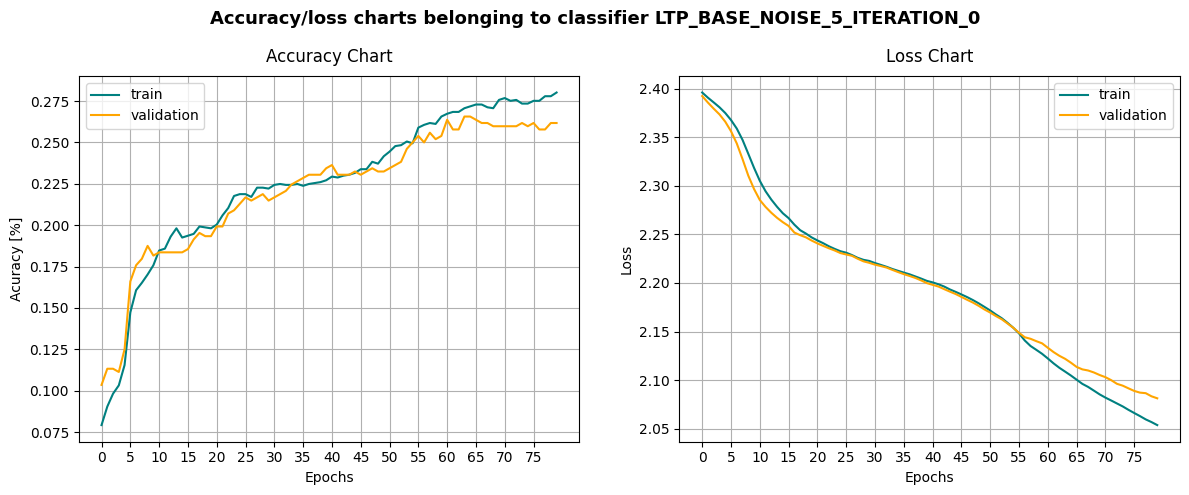

In [15]:
#CHARTING TRAINING PERFORMANCES

STEP = 2 if NUMAR_EPOCI == 20 else 5
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

SUPTITLE = ('Accuracy/loss charts belonging to classifier '+ MODEL_NAME)
titlu_acuratete = 'Accuracy Chart'
titlu_pierdere = 'Loss Chart'
TITLEFONT = 12

plt.suptitle(SUPTITLE, fontsize = 13, fontweight = 'bold')

# Subplot pentru graficul de acuratete
axs[0].plot(hist.history['accuracy'], color='teal', label='train')
axs[0].plot(hist.history['val_accuracy'], color='orange', label='validation')
axs[0].set_title(titlu_acuratete, fontsize=TITLEFONT ,pad = 10)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acuracy [%]')
axs[0].legend(loc = "upper left")
axs[0].set_xticks(np.arange(0,len(hist.history['accuracy']),STEP))
axs[0].set_xticklabels(np.arange(0, len(hist.history['accuracy']),STEP))
axs[0].grid(True)

# Subplot pentru graficul de pierdere
axs[1].plot(hist.history['loss'], color='teal', label='train')
axs[1].plot(hist.history['val_loss'], color='orange', label='validation')
axs[1].set_title(titlu_pierdere, fontsize=TITLEFONT, pad  = 10)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(loc = "upper right")
axs[1].set_xticks(np.arange(0,len(hist.history['loss']),STEP))
axs[1].set_xticklabels(np.arange(0, len(hist.history['loss']),STEP))
axs[1].grid(True)


plt.tight_layout()
plt.subplots_adjust(wspace = 0.2)
plt.savefig ('Antrenare_'+MODEL_NAME+'.png',dpi=150, bbox_inches='tight',pad_inches = 0.1)
plt.show()

# Optional Performance Metrics Evaluation

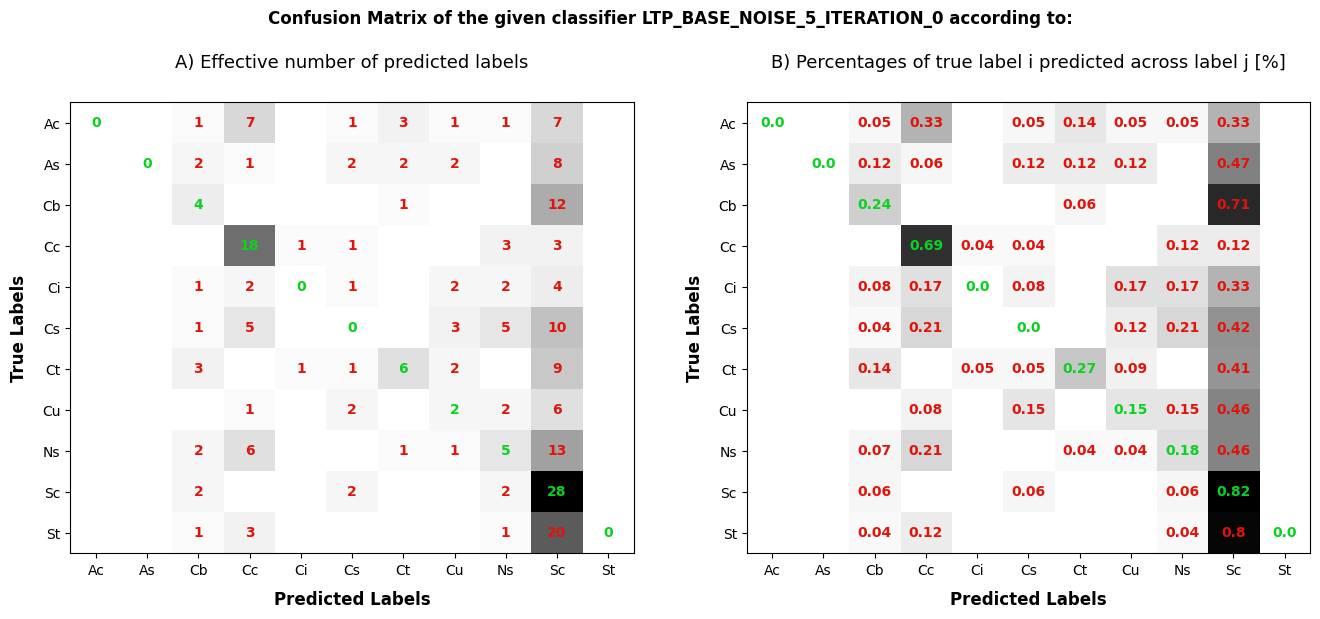




1) PERFORMANCE METRICS PER CLASS:

Class  | Precision  |    Recall    |  F1-score  |
-------------------------------------------------
Ac     |      0.00  |        0.00  |      0.00  |
-------|------------|--------------|------------|
As     |      0.00  |        0.00  |      0.00  |
-------|------------|--------------|------------|
Cb     |      0.24  |        0.24  |      0.24  |
-------|------------|--------------|------------|
Cc     |      0.42  |        0.69  |      0.52  |
-------|------------|--------------|------------|
Ci     |      0.00  |        0.00  |      0.00  |
-------|------------|--------------|------------|
Cs     |      0.00  |        0.00  |      0.00  |
-------|------------|--------------|------------|
Ct     |      0.46  |        0.27  |      0.34  |
-------|------------|--------------|------------|
Cu     |      0.15  |        0.15  |      0.15  |
-------|------------|--------------|------------|
Ns     |      0.24  |        0.18  |      0.20  |
-------|----

In [17]:
ytrue, ypred = extrage_predictii(clasificator,test,sanitizare_CNN = False)

afiseaza_matrice_confuzie(ytrue,ypred, MODEL_NAME)
print('\n\n')
dict_masuri = calculeaza_metrici_performanta (ytrue, ypred)